In [43]:
import pandas as pd
import matplotlib.pyplot as ptl
import seaborn as sns
import numpy as np

## PRVER O CUSTO DO SEGURO

In [45]:
df = pd.read_csv('insurance.csv')
df.head()

,idade,sexo,imc,quantidade_filhos,fumante,regiao,custos_seguro
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.560,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1341 entries, 0 to 1340
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   idade              1341 non-null   int64  
 1   sexo               1338 non-null   object 
 2   imc                1341 non-null   float64
 3   quantidade_filhos  1341 non-null   int64  
 4   fumante            1341 non-null   object 
 5   regiao             1341 non-null   object 
 6   custos_seguro      1341 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.5+ KB


In [47]:
df['sexo'] = df['sexo'].fillna(df['sexo'].mode()[0])

In [48]:
df.describe()

,idade,imc,quantidade_filhos,custos_seguro
count,1341.000000,1341.000000,1341.000000,1341.000000
mean,39.186428,30.684903,1.092468,13240.734520
std,14.040969,6.107806,1.205254,12112.696927
min,18.000000,15.960000,0.000000,0.000000
25%,27.000000,26.315000,0.000000,4719.524050
50%,39.000000,30.400000,1.000000,9361.326800
75%,51.000000,34.770000,2.000000,16586.497710
max,64.000000,53.130000,5.000000,63770.428010


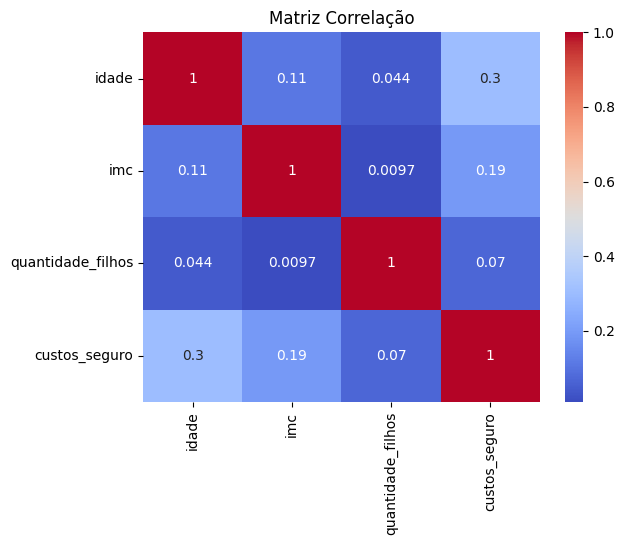

In [49]:
corr_matriz = df.corr(numeric_only=True)
sns.heatmap(corr_matriz, annot=True, cmap='coolwarm')
ptl.title('Matriz Correlação')
ptl.show()

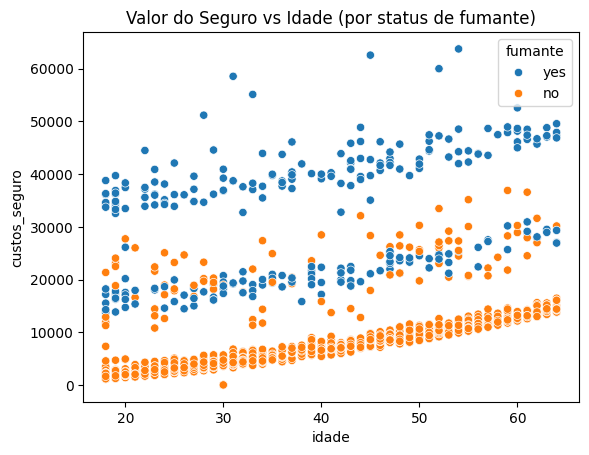

In [50]:
# Relação entre idade e valor do seguro (gráfico de dispersão)
sns.scatterplot(data=df, x='idade', y='custos_seguro', hue='fumante')
ptl.title("Valor do Seguro vs Idade (por status de fumante)")
ptl.show()

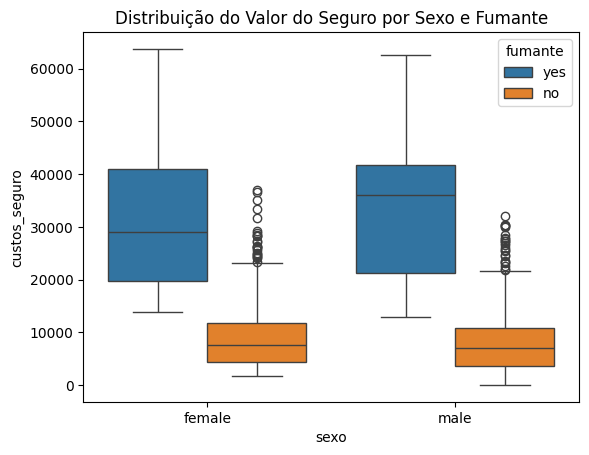

In [51]:
# Boxplot para comparar valor do seguro por sexo e fumante
sns.boxplot(data=df, x='sexo', y='custos_seguro', hue='fumante')
ptl.title("Distribuição do Valor do Seguro por Sexo e Fumante")
ptl.show()

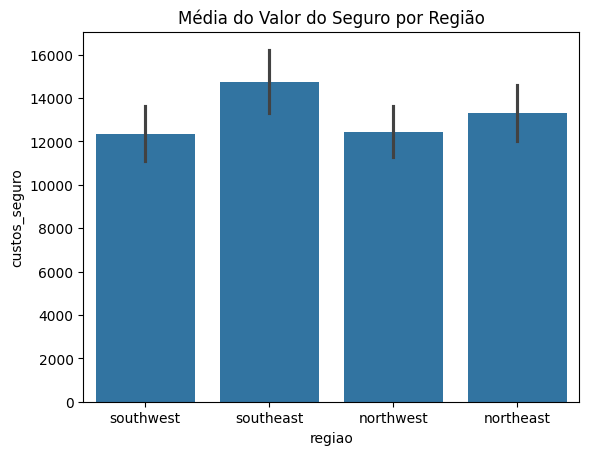

In [52]:
# Média do valor do seguro por região
sns.barplot(data=df, x='regiao', y='custos_seguro', estimator='mean')
ptl.title("Média do Valor do Seguro por Região")
ptl.show()

In [ ]:
#verificar a existência outliers na coluna 'valor_seguro'

Q1 = df['custos_seguro'].quantile(0.25)
Q3 = df['custos_seguro'].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df[(df['custos_seguro'] < limite_inferior) | (df['custos_seguro'] > limite_superior)]
print(f"Número de outliers em 'valor_seguro': {len(outliers)}")

Número de outliers em 'valor_seguro': 141


In [54]:
df = pd.get_dummies(df, columns=['sexo', 'fumante', 'regiao'])

In [55]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [56]:
X = df.drop('custos_seguro', axis=1)
y = df['custos_seguro']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [57]:
# Dicionário para armazenar resultados
resultados = {}

In [ ]:
#Random Forest 
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

resultados['RandomForest'] = {
    'MSE': mean_squared_error(y_test, y_pred_rf),
    'R²': r2_score(y_test, y_pred_rf)
}

In [59]:
#XGBoost ---
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

resultados['XGBoost'] = {
    'MSE': mean_squared_error(y_test, y_pred_xgb),
    'R²': r2_score(y_test, y_pred_xgb)
}

In [60]:
# Mostrar resultados
for modelo, metrics in resultados.items():
    print(f"\n{modelo}:")
    print(f"  MSE: {metrics['MSE']:.2f}")
    print(f"  R²: {metrics['R²']:.4f}")


RandomForest:
  MSE: 25719882.49
  R²: 0.8108

XGBoost:
  MSE: 28680120.47
  R²: 0.7891


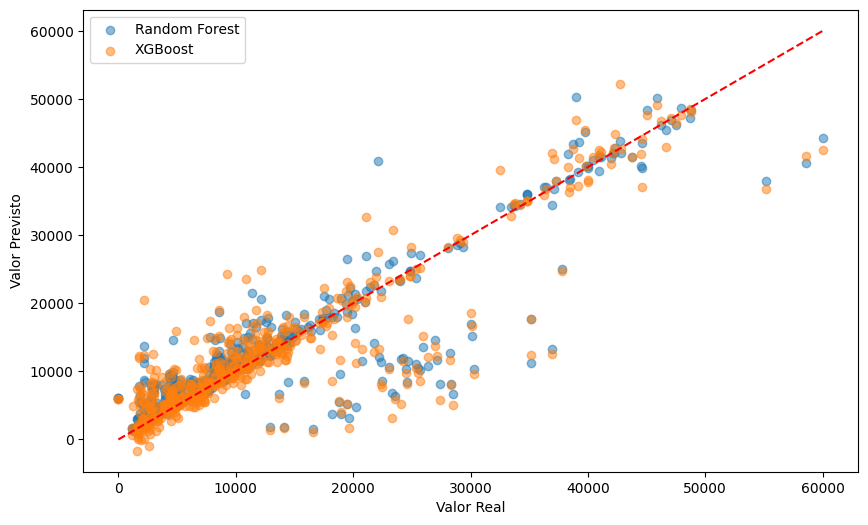

In [61]:
import matplotlib.pyplot as plt

# Comparar previsões dos modelos
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5, label='Random Forest')
plt.scatter(y_test, y_pred_xgb, alpha=0.5, label='XGBoost')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Valor Real")
plt.ylabel("Valor Previsto")
plt.legend()
plt.show()

In [62]:
#Otimizando o hiperparâmetros do Random Forest

param_grid_RF ={
            'n_estimators': [50, 100, 200], # Número de árvores
            'max_depth': [3, 5, 7],         # Profundidade máxima
            'min_samples_split': [2, 5, 10] # Mínimo de amostras para dividir
}

#aplicando Grid Search
scoring={'r2': 'r2', 'mse': 'neg_mean_squared_error'}
grid_search = GridSearchCV(rf, param_grid_RF, cv=5, scoring=scoring, refit='r2')
grid_search.fit(X_train, y_train)


print('Melhores hiperparâmetros:', grid_search.best_params_)
print('Melhor score R2:', grid_search.best_score_)

Melhores hiperparâmetros: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}
Melhor score R2: 0.8694153526189734


In [63]:
#Otimizando o hiperparâmetros do XGBoost

param_grid_XGB = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Taxa de aprendizado pequena a moderada
    'max_depth': [3, 5, 7, 10],               # Profundidade da árvore, mais profunda aumenta a complexidade
    'n_estimators': [50, 100, 200, 300],       # Número de árvores no modelo
    'subsample': [0.6, 0.8, 1.0]               # Proporção de amostras para cada árvore
}

grid_search_XGB = GridSearchCV(xgb, param_grid_XGB, cv=5, scoring='r2')
grid_search_XGB.fit(X_train, y_train)

print('Melhores hiperparâmetros:', grid_search_XGB.best_params_)
print('Melhor score R2:', grid_search_XGB.best_score_)

Melhores hiperparâmetros: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
Melhor score R2: 0.8712290329776883


In [64]:
# Validação Cruzada

# Modelos otimizados com os melhores hiperparâmetros encontrados
rf_model = RandomForestRegressor(
    max_depth= 5, 
    min_samples_split= 5, 
    n_estimators = 200,
    random_state=42
)

xgb_model = XGBRegressor(
    learning_rate= 0.1, 
    max_depth= 3, 
    n_estimators= 50, 
    subsample= 0.8,
    random_state=42
)

# Realizando a validação cruzada com 10 folds para cada modelo
cv_folds= 10
scoring= 'r2'


rf_score = cross_val_score(rf_model, X_train, y_train, cv=cv_folds, scoring=scoring)
xgb_score = cross_val_score(xgb_model, X_train, y_train, cv=cv_folds, scoring=scoring)

print(f"Random Forest - Média R²: {np.mean(rf_score):.4f} ± {np.std(rf_score):.4f}")
print(f"XGBoost - Média R²: {np.mean(xgb_score):.4f} ± {np.std(xgb_score):.4f}")

Random Forest - Média R²: 0.8676 ± 0.0489
XGBoost - Média R²: 0.8701 ± 0.0502
